In [86]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from datetime import datetime 
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import csv

# normalizing features
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
#from keras.layers import Conv2D
import os
from tensorflow.keras.applications.vgg16 import VGG16

#XGBOOST
import xgboost as xgb

from model_metrics import iou_acc, dice_acc, pixel_acc


In [58]:
# calculating IoU and dice accuracy of trained model
SIZE_X = 512 #Resize images (height  = X, width = Y)
SIZE_Y = 512

file_path = "D:/Anil/Dataset/gray_mold/val/"
gt_path = "D:/Anil/Dataset/gray_mold/val/GT/"
val_images = []
val_masks = []
file_names = []

for img_path in glob.glob(os.path.join(file_path,'*.png')):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    val_images.append(img)
    file_names.append(os.path.basename(img_path))

#Convert list to array for machine learning processing        
val_images = np.array(val_images)

# Ground truth image array
for mask_path in glob.glob(os.path.join(gt_path,"*.png")):
    mask = cv2.imread(mask_path, 0)       
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    mask[mask > 0] = 255
    #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
    val_masks.append(mask)
    #train_labels.append(label)
    
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)


In [66]:
# Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [93]:
# Load xgb model
xgb_model = xgb.XGBClassifier()

filename = 'D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf5/model_XG.sav'
xgb_model = pickle.load(open(filename, 'rb'))


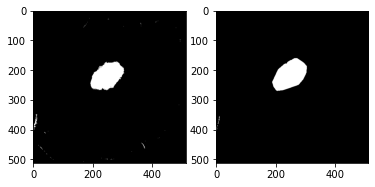

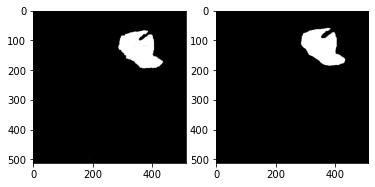

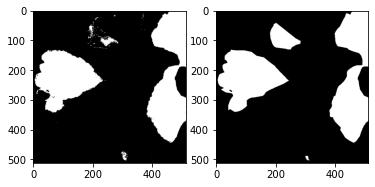

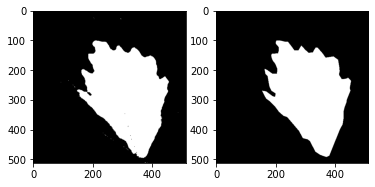

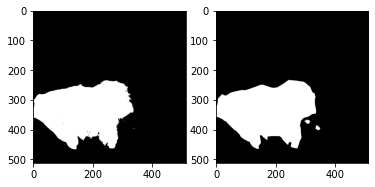

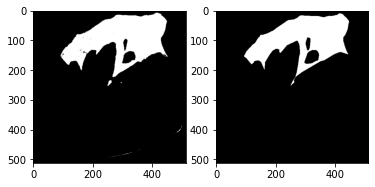

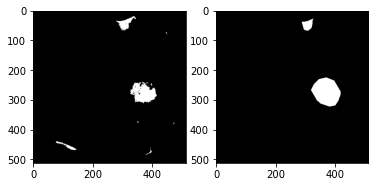

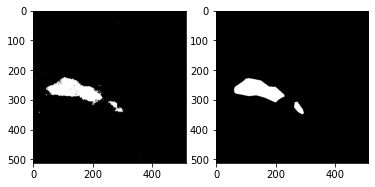

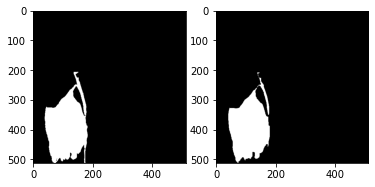

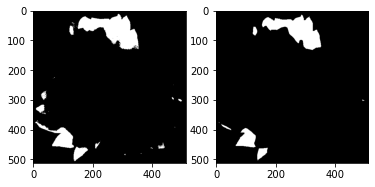

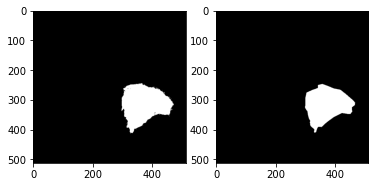

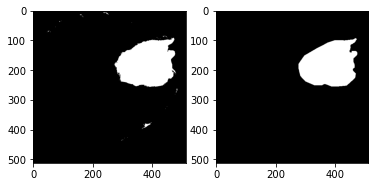

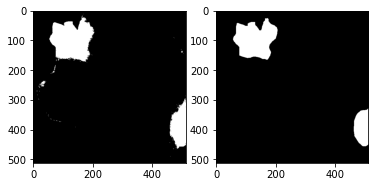

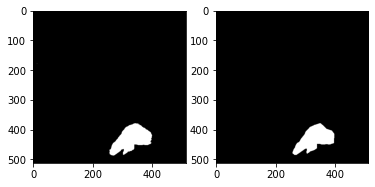

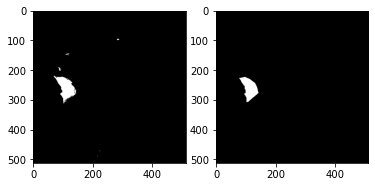

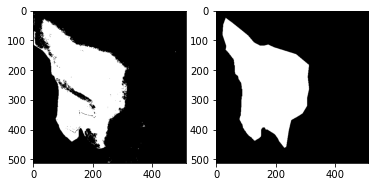

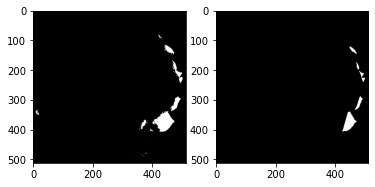

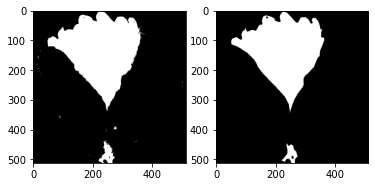

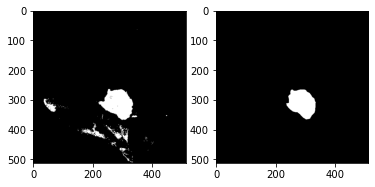

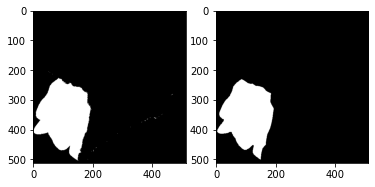

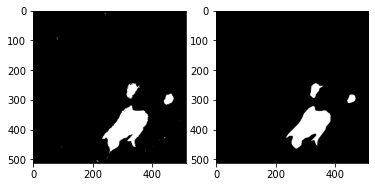

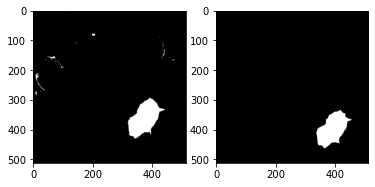

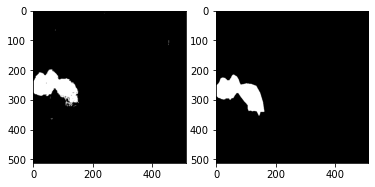

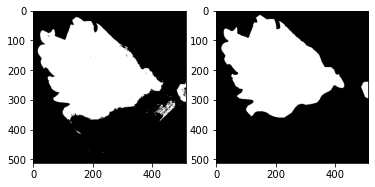

total time to test:  0:00:08.922514


In [94]:
from datetime import datetime
# normalizing test data
mc = MinMaxScaler()

result_path = 'D:/Anil/Dataset/gray_mold/predicted_image/'

# testing images and save iou and dice coefficient in file
csv_path = "D:/Anil/Dataset/gray_mold/xgb_kf5.csv"
csv_header = ['SN','iou','dice','accuracy']
start = datetime.now()
with open (csv_path,'w', newline='')as csvfile:
    # create a csv writer object
    csvwriter = csv.writer(csvfile)
    
    # writing the header field
    csvwriter.writerow(csv_header)
    
    for i in range (len(val_images)):
        val_img = val_images[i]
        val_img = np.expand_dims(val_img, axis=0)
        val_feature = new_model.predict(val_img)
        x_val_feature = val_feature.reshape(-1, val_feature.shape[3])
        x_val_feature = mc.fit_transform(x_val_feature)

        prediction_xgb = xgb_model.predict(x_val_feature)
        predict_img = prediction_xgb.reshape(val_masks[0].shape)
        
        truth_img = val_masks[i]
        GT = truth_img.reshape(-1)
        
        #saving segmented images
        img_path = result_path+'xgb_'+file_names[i]
        cv2.imwrite(img_path,predict_img)
        
        fig,(ax1,ax2) = plt.subplots(1,2)
        
        ax1.imshow(predict_img,cmap='gray')
        ax2.imshow(truth_img,cmap='gray')
        plt.show()
        
        acc = pixel_acc(GT, prediction_xgb)
        iou = iou_acc(truth_img/255.0, predict_img/255.0)
        iou = iou.numpy() # numpy() is to convert tf.tesnsor to numpy to get values
        dice = dice_acc(truth_img/255.0, predict_img/255.0)
        dice = dice.numpy()
#         iou = K.eval(iou_coef(y_true=truth_img/255.0, y_pred=predict_img/255.0))
        
#         dice = K.eval(dice_coef(y_true=truth_img/255.0, y_pred=predict_img/255.0))
        
#         acc = accuracy_score(GT, prediction_xgb)
        
        row_content = [i,iou,dice,acc]
        csvwriter.writerow(row_content)
        
stop = datetime.now()
print("total time to test: ",stop-start)


In [47]:
# Load xgb model
xgb_model = xgb.XGBClassifier()

filename = 'D:/Anil/Dataset/gray_mold/lgb_data/k-fold/kf1/model_XG.sav'
xgb_model = pickle.load(open(filename, 'rb'))

In [48]:
prediction_xgb = xgb_model.predict(X_validation_feature)


In [54]:
prediction_xgb = prediction_xgb*255
predict_img = prediction_xgb.reshape((24,512,512))
predict_img.shape


(24, 512, 512)

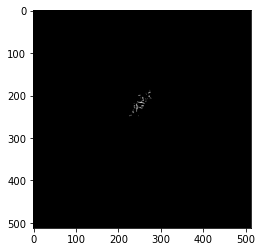

In [55]:
plt.imshow(predict_img[0],cmap = 'gray')
plt.show()